Assignment 1: 

Name: Young-Shiuan Hsu

UID: 118339238

Please submit to Gradescope
- a PDF containing all outputs (by executing **Run all**)
- your ipynb notebook containing all the code

I understand the policy on academic integraty (collaboration and the use of online material).
Please sign your name here: Young-Shiuan Hsu


# Part A: Hybrid Image (25 Points)

## Overview

A hybrid image is the sum of a *low-pass filtered* version of the one image and a *high-pass filtered* version of a second image. There is a free parameter, which can be tuned for each image pair, which controls how much high frequency to remove from the first image and how much low frequency to leave in the second image. This is called the “cutoff-frequency”. In the paper it is suggested to use two cutoff frequencies (one tuned for each image) and you are free to try that, as well. In the starter code, the cutoff frequency is controlled by changing the standard deviation of the Gausian filter used in constructing the hybrid images. [This](https://drive.google.com/uc?id=187FjBJLwnYXhylx08Vdh1SAA3AO-imYv) is the sample example.

NOTE: 

1. Reading [this](https://stanford.edu/class/ee367/reading/OlivaTorralb_Hybrid_Siggraph06.pdf) will help in understanding Part A.

2. You can use any image processing libraries of your choice such as skimage or cv2; in python.

We provided 7 pairs of aligned images. The alignment is important because it affects the perceptual grouping (read the paper for details). We encourage you to create additional examples (e.g. change of expression, morph between different objects, change over time, etc.).

You are required to provide **THREE hybrid image results** and for ONE of your favorite result, please provide answers to the following **FOUR sub-parts** mentioned in the write-up.

## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [1]:
# Download Data -- run this cell only one time per runtime
!gdown 1KTDxPAkQam29YKtoX5dKPnLKpUOWCanC
# !unzip "/content/hybrid_pyramid_input.zip" -d "/content/"
'''
I commented this line because my computer cannot run unzip command
I unziped the file manually to a "hybrid_pyramid_input folder"
'''

Downloading...
From: https://drive.google.com/uc?id=1KTDxPAkQam29YKtoX5dKPnLKpUOWCanC
To: C:\Users\USER\Documents\School\Semester3\CMSC 733 CV\HW1\hybrid_pyramid_input.zip

  0%|          | 0.00/2.19M [00:00<?, ?B/s]
100%|##########| 2.19M/2.19M [00:00<00:00, 23.2MB/s]


'\nI commented this line because my computer cannot run unzip command\nI unziped the file manually to a "hybrid_pyramid_input folder"\n'

## Code

In [6]:
# Helper Functions

def vis_hybrid_image(hybrid_image):
    scales = 5
    scale_factor = 0.5
    padding = 5
    original_height = hybrid_image.shape[0]
    num_colors = hybrid_image.shape[2] # counting how many color channels the input has
    output = hybrid_image
    cur_image = hybrid_image

    for i in range(2, scales):
      # add padding
        output = np.concatenate((output, np.ones((original_height, padding, num_colors), dtype=int)), axis=1)      
      # dowsample image;
        width = int(cur_image.shape[1] * scale_factor)
        height = int(cur_image.shape[0] * scale_factor)
        dim = (width, height)
        cur_image = cv2.resize(cur_image, dim, interpolation = cv2.INTER_LINEAR)
      # pad the top and append to the output
        tmp = np.concatenate((np.ones((original_height-cur_image.shape[0], cur_image.shape[1], num_colors)), cur_image), axis=0)
        output = np.concatenate((output, tmp), axis=1)
    output = (output * 255).astype(np.uint8)
    return output

def read_image(image_path):
    from PIL import Image
    image = Image.open(image_path)
    image = np.array(image)
    return image 

def gaussian_2D_filter(row, col, cutoff_frequency):
    ## cutoff frequency is the standard deviation of the gaussian filter
    ## the gaussian filter has zero mean
    import math
    filter = np.zeros((row, col))
    for i in range(row):
        for j in range(col):
            x = i - math.floor(row/2)
            y = j - math.floor(col/2)
            filter[i][j] = (1/(2*math.pi*cutoff_frequency))*math.exp(-1*(x**2 + y**2)/(2*(cutoff_frequency**2)))
            
    ## saturation could occur if the kernel is not normalized(all the element has to sum up to 1)
    adder = 0   
    for i in range(row):
        for j in range(col):
            adder += filter[i][j]  
    
    # normalize the kerel
    for i in range(row):
        for j in range(col):
            filter[i][j] = filter[i][j] / adder
    
    return filter

def imgfilter(image, filter):
    from scipy import signal
    new_img = cv2.filter2D(image, ddepth=-1, kernel=filter)
    
    return new_img

def log_mag_FFT(image):
    channels = image.shape[2]
    fft_mag_image = np.log(np.abs(np.fft.fftshift(np.fft.fft2(image))))
    
    return fft_mag_image

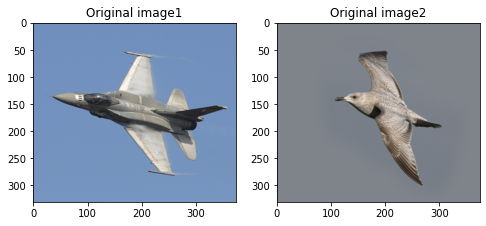

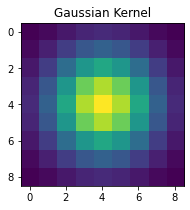

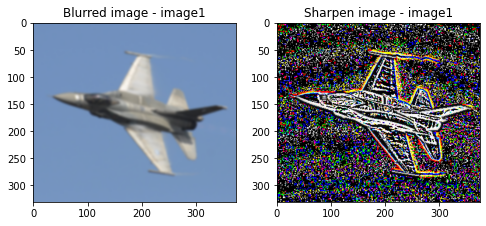

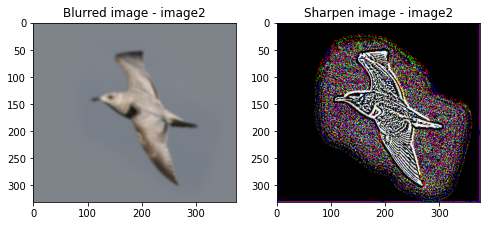

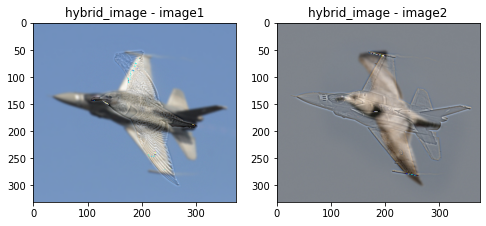

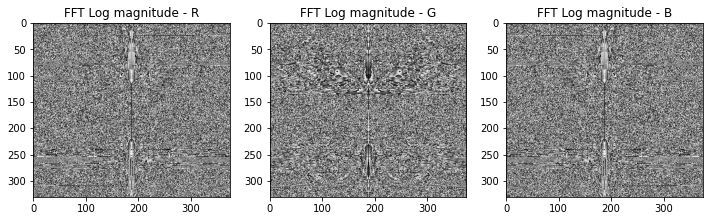

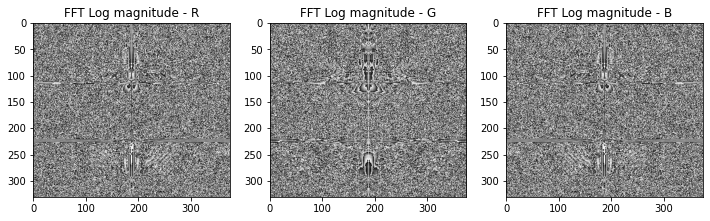

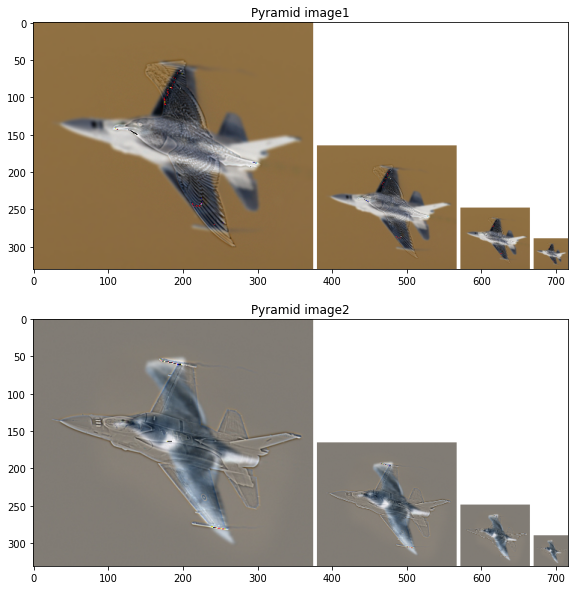

In [7]:
# Import necessary packages here
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import math 
from scipy import signal

image_path1 = "hybrid_pyramid_input/data/plane.bmp"
image_path2 = "hybrid_pyramid_input/data/bird.bmp"

image_1 = read_image(image_path1)
image_2 = read_image(image_path2)

# YOUR CODE HERE: TUNE cutoff_frequency
cutoff_frequency = 2
filter_size = cutoff_frequency*4+1
"""cutoff_frequency is the standard deviation, in pixels, of the 
Gaussian blur that will remove the high frequencies from one image (image_1) and 
remove the low frequencies from another image (image_2) (to do so, subtract a blurred
version from the original version). You will want to tune this for every image pair to get the best results."""

#filter = gaussian_2D_filter((filter_size, filter_size), cutoff_frequency) this doesn't work on my laptop
filter = gaussian_2D_filter(filter_size, filter_size, cutoff_frequency)


"""Use imgfilter() to create 'low_frequencies' and 'high_frequencies' and then combine them to create 'hybrid_image'.
Remove the high frequencies from image_1 by blurring it. The amount of blur that works best will vary with different image pairs."""

# low_frequencies
blurred_image1 = imgfilter(image_1, filter=filter)
blurred_image2 = imgfilter(image_2, filter=filter)

"""Remove the low frequencies from image_2. The easiest way to do this is to
subtract a blurred version of image_2 from the original version of image_2.
This will give you an image centered at zero with negative values."""

# high_frequencies
sharpen_image1 = image_1 - blurred_image1
sharpen_image2 = image_2 - blurred_image2

"""Combine the high frequencies and low frequencies to obtain hybrid_image."""
hybrid_image1 = blurred_image1 + sharpen_image2 
hybrid_image2 = blurred_image2 + sharpen_image1

"""Firstly, visualize low_frequencies, high_frequencies, and the hybrid image."""
fig_ori = plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.title("Original image1")
plt.imshow(image_1)
plt.subplot(1,2,2)
plt.title('Original image2')
plt.imshow(image_2)
fig_ori.savefig('Output/pb1/Original image.png')


fig_kernel = plt.figure(figsize = (3,3))
plt.title('Gaussian Kernel')
plt.imshow(filter)
fig_kernel.savefig("Output/pb1/Gaussian kerenl.png")

pro_img1_fig = plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.title('Blurred image - image1')
plt.imshow(blurred_image1)
plt.subplot(1,2,2)
plt.title("Sharpen image - image1")
plt.imshow(sharpen_image1)
pro_img1_fig.savefig("Output/pb1/Processed Image1.png")

pro_img2_fig = plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.title('Blurred image - image2')
plt.imshow(blurred_image2)
plt.subplot(1,2,2)
plt.title("Sharpen image - image2")
plt.imshow(sharpen_image2)
pro_img2_fig.savefig("Output/pb1/Processed Image2.png")

hybrid_fig = plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.title('hybrid_image - image1')
plt.imshow(hybrid_image1)
plt.subplot(1,2,2)
plt.title('hybrid_image - image2')
plt.imshow(hybrid_image2)
hybrid_fig.savefig("Output/pb1/Hybrid Image.png")

"""Secondly, also visualize log magnitude of Fourier Transform of the above.
HINT: You may use np.log(np.abs(np.fft.fftshift(np.fft.fft2(image)))) to achieve it."""
## process hybrid_image1
FFT_image = log_mag_FFT(hybrid_image1)  ## process a RBG image
FFT_image = (FFT_image*255).astype(np.uint8)

FFT_img1_fig = plt.figure(figsize = (12,12))
plt.subplot(1,3,1)
plt.title('FFT Log magnitude - R')  ## present RGB component seperately
plt.imshow(FFT_image[:,:,0], cmap = 'gray')
plt.subplot(1,3,2)
plt.title('FFT Log magnitude - G')  ## present RGB component seperately
plt.imshow(FFT_image[:,:,1], cmap = 'gray')
plt.subplot(1,3,3)
plt.title('FFT Log magnitude - B')  ## present RGB component seperately
plt.imshow(FFT_image[:,:,2], cmap = 'gray')
FFT_img1_fig.savefig("Output/pb1/FFT_image1.png")

## process hybrid image2
FFT_image = log_mag_FFT(hybrid_image2)  ## process a RBG image
FFT_image = (FFT_image*255).astype(np.uint8)

FFT_img2_fig = plt.figure(figsize = (12,12))
plt.subplot(1,3,1)
plt.title('FFT Log magnitude - R')  ## present RGB component seperately
plt.imshow(FFT_image[:,:,0], cmap = 'gray')
plt.subplot(1,3,2)
plt.title('FFT Log magnitude - G')  ## present RGB component seperately
plt.imshow(FFT_image[:,:,1], cmap = 'gray')
plt.subplot(1,3,3)
plt.title('FFT Log magnitude - B')  ## present RGB component seperately
plt.imshow(FFT_image[:,:,2], cmap = 'gray')
FFT_img2_fig.savefig("Output/pb1/FFT_image2.png")


"""Thirdly, visualize hybrid_image_scale using helper function vis_hybrid_image.
Lastly, save all your outputs."""
pyramid_img1 = vis_hybrid_image(hybrid_image1)
pyramid_img2 = vis_hybrid_image(hybrid_image2)

pyramid_fig = plt.figure(figsize = (25,10))
plt.subplot(2,1,1)
plt.title("Pyramid image1")  ## present RGB component seperately
plt.imshow(pyramid_img1)
plt.subplot(2,1,2)
plt.title("Pyramid image2")  ## present RGB component seperately
plt.imshow(pyramid_img2)
pyramid_fig.savefig("Output/pb1/Pyramid.png")


## **Write-up**


1.   Provide the original and filtered images.
2.   Provide the the hybrid image and hybrid_image_scale using given helper function *vis_hybrid_image*.
3.   Log magnitude of the Fourier transform of the two original images, the filtered images, and the hybrid image.
4.   Briefly explain how this works, using your favorite results as illustrations.

**Include your write-up here**

# Part B: Pyramid Image (25 Points)

## Overview
Choose an image that has interesting variety of textures (from Flickr or your own images). The images should be atleast 640X480 pixels and converted to grayscale. Write code for a Gaussian and Laplacian pyramid of level N (use for loops). In each level, the resolution should be reduced by a factor of 2. Show the pyramids for your chosen image in your write-up. Here is an [example](https://drive.google.com/uc?id=17Y287EA-GJ2z0wtm_M7StIWsXyFeHvrz).

## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [ ]:
# Download Data -- run this cell only one time per runtime
!gdown 1KTDxPAkQam29YKtoX5dKPnLKpUOWCanC
!unzip "/content/hybrid_pyramid_input.zip" -d "/content/"

## Code

In [ ]:
# Populate Helper Functions:

def pyramidsGL(image, num_levels):
  ''' Creates Gaussian (G) and Laplacian (L) pyramids of level "num_levels" from image im. 
  G and L are list where G[i], L[i] stores the i-th level of Gaussian and Laplacian pyramid, respectively. '''
  # YOUR CODE HERE
  return G, L

def displayPyramids(G, L):
  '''Role of this function is to display intensity and Fast Fourier Transform (FFT) images of pyramids.
  NOTE: You may re-use your helper function  "log_mag_FFT" to compute this.'''
  # YOUR CODE HERE
  return

def reconstructLaplacianPyramid(L):
  '''Given a Laplacian Pyramid L, reconstruct an image img.'''
  # YOUR CODE HERE 
  return img
  

In [ ]:
""" 
Steps:
1. Load an image im.
2. Call function pyramidsGL with image and num_levels = 5
3. Call function displayPyramids with G, L
4. Call function reconstructLaplacianPyramid with the generated L
5. Compute reconstruction error with L2 norm and print the error value.
"""

# YOUR CODE HERE

## **Write-up**

1. (10 Points) Display a Gaussian and Laplacian pyramid of level 5 (using your code). It should be formatted similar to [this](https://drive.google.com/file/d/1mAommQeJsp7WS8QCrZRcr8cQiltPPOh2/view?usp=sharing) figure.

2. (10 Points) Display the FFT amplitudes of your Gaussian/Laplacian pyramids Appropriate display ranges (from 0 to 1) should be chosen so that the changes in frequency in different levels of the pyramid are clearly visible. Explain  what the Laplacian and Gaussian pyramids are doing in terms of frequency. [This](https://drive.google.com/file/d/1BqTPKq6Mqqxl5jNNPkvx4JOA5MRgVq08/view?usp=sharing) looks like the expected output.

3. (5 Points) Image Reconstruction


**Include your write-up here**

# Part C: Edge detection (25 points)

## Overview
The main steps of edge detection are: (1) assign a score to each pixel; (2) find local maxima along the direction perpendicular to the edge. Sometimes a third step is performed where local evidence is propagated so that long contours are more confident or strong edges boost the confidence of nearby weak edges. Optionally, a thresholding step can then convert from soft boundaries to hard binary boundaries. Here are sample outputs.

<table><tr>
<td> <img src="https://drive.google.com/uc?id=1orUji5-1CzjWmHk0g5y5kOVFhshNfhN8" alt="Drawing" style="width: 250px;"/> </td>
<td> <img src="https://drive.google.com/uc?id=1npyMjhlRAeP1GaukV38SOlCe-O0whX37" alt="Drawing" style="width: 250px;"/> </td>
</tr></table>
<table><tr>
<td> <img src="https://drive.google.com/uc?id=1TX54zNTG6q5ajitwV024FS-nOJiVP2VN" alt="Drawing" style="width: 250px;"/> </td>
<td> <img src="https://drive.google.com/uc?id=1dPPSFDmakh8DQwlpTYmNXJPNHapdZF8S" alt="Drawing" style="width: 250px;"/> </td>
</tr></table>

**Hint:** Reading these papers will help understanding and may help with the programming assignment.

[The design and use of steerable filters](http://people.csail.mit.edu/billf/papers/steerpaper91FreemanAdelson.pdf)

[Berkeley Pb Detector](https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/papers/mfm-pami-boundary.pdf)

[Multi-scale edge detection](https://home.ttic.edu/~xren/publication/xren_eccv08_multipb.pdf)

## Data
We have provided 50 test images and the codes associated to download the unzip the data. Your job is to build a simple gradient-based edge detector and to extend it using multiple oriented filters.

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [27]:
# Download Data -- run this cell only one time per runtime
!gdown 1zgblBWTQ847yZKnRmM1QrRiEWu1WvEo7
# !unzip "/content/edge_detection_inputs.zip" -d "/content/"

Downloading...
From: https://drive.google.com/uc?id=1zgblBWTQ847yZKnRmM1QrRiEWu1WvEo7
To: C:\Users\USER\Documents\School\Semester3\CMSC 733 CV\HW1\edge_detection_inputs.zip

  0%|          | 0.00/3.82M [00:00<?, ?B/s]
 69%|######8   | 2.62M/3.82M [00:00<00:00, 22.5MB/s]
100%|##########| 3.82M/3.82M [00:00<00:00, 23.2MB/s]
'unzip' is not recognized as an internal or external command,
operable program or batch file.


image size: (321, 481, 3)


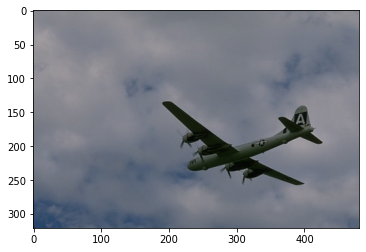

In [8]:
# Import necessary packages
import numpy as np
import cv2
from PIL import Image
    
# from google.colab.patches import cv2_imshow ## Use this to show image in colab

img_path = "edge_detection_inputs/3096.jpg" ## add the path here
img = cv2.imread(img_path)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) 
print("image size:", img.shape)  
#should we comput the grayscale image?

## Subpart 1: Simple edge detection (8 points)
Build a simple gradient-based edge detector that includes the following functions
```
def gradientMagnitude(im, signma)
```
This function should take an RGB image as input, smooth the image with Gaussian std=sigma, compute the x and y gradient values of the smoothed image, and output image maps of the gradient magnitude and orientation at each pixel. You can compute the gradient magnitude of an RGB image by taking the L2-norm of the R, G, and B gradients. The orientation can be computed from the channel corresponding to the largest gradient magnitude. The overall gradient magnitude is the L2-norm of the x and y gradients. mag and theta should be the same size as im.

```
def edgeGradient(im):
```
This function should use gradientMagnitude to compute a soft boundary map and then perform non-maxima suppression. For this assignment, it is acceptable to perform non-maxima suppression by retaining only the magnitudes along the binary edges produce by the Canny edge detector: `cv2.Canny(im)`. 

If desired, the boundary scores can be rescaled, e.g., by raising to an exponent: `mag2 = mag.^0.7` , which is primarily useful for visualization. 


In [148]:
# This website is very helpful
#https://pyimagesearch.com/2021/05/12/image-gradients-with-opencv-sobel-and-scharr/#:~:text=The%20gradient%20magnitude%20is%20used,change%20in%20intensity%20is%20pointing.
import math


class img_gradient():
    def _init_(self, x=0, y=0, ori=0):
        self.x = x
        self.y = y
        self.ori = ori
        
    def cal_magnitude(self):
        self.mag = math.sqrt(self.x **2 + self.y**2)
        
        
def zero_padding(img, add):      ## to help calculate the edges in the image
    row = img.shape[0] + (add*2)
    col = img.shape[1] + (add*2)
    chan = img.shape[2]
    new_img = np.zeros((row,col,chan))
    for i in range(img.shape[2]):
        for j in range(img.shape[0]):
            for k in range(img.shape[1]):
                new_img[j+add][k+add][i] = img[j][k][i]
    return new_img

def patch_gradient(patch):
    patchsize = patch.shape[0]
    center = math.floor(patchsize/2)
    
    x_direction = 0
    y_direction = 0
    for i in range(patchsize):
        if i < center:
            y_direction -= patch[i][center]
            x_direction -= patch[center][i]
        if i > center:
            y_direction += patch[i][center]
            x_direction += patch[center][i]
            
    if x_direction == 0:
        if y_direction > 0:
            ori = 90.0
        elif y_direction < 0:
            ori = -90.0
        else:
            ori = math.atan(y_direction) * (180/math.pi)
    elif x_direction > 0:
        ori = math.atan(y_direction/x_direction) * (180/math.pi)
        
    else:
        if y_direction < 0:
            ori = ( math.atan(y_direction/x_direction) * (180/math.pi) ) - 180
        else:
            ori = (math.atan(y_direction/x_direction) * (180/math.pi)) + 180
    
    return x_direction, y_direction, ori
    

def gradientMagnitude(im, sigma):
    '''
    im: input image
    sigma: standard deviation value to smooth the image
    outputs: gradient magnitude and gradient direction of the image
    '''
    print("Calculating Gradient of the image...")
    ## create a gaussian low pass filter
    filter_size = 10
    kernel = gaussian_2D_filter(filter_size, filter_size, sigma)
    blur_img = imgfilter(im, kernel)  ## blur the image 
    
    patch_size = 3
    half_patch_size = math.floor(patch_size/2)
    stride = 1
    ## padding the image to also calcuate the edges of the image
    blur_img = zero_padding(blur_img, half_patch_size)  
    row = blur_img.shape[0]
    col = blur_img.shape[1]
    channels = blur_img.shape[2]
#     print("Padded image size:", row, col, channels)
    
    R_component = []
    G_component = []
    B_component = []
    for i in range(half_patch_size, row-half_patch_size, 1):
        R_row_component = []
        G_row_component = []
        B_row_component = []
        for j in range(half_patch_size, col-half_patch_size, 1):
            ## create patches to calculate the gradient later
            patch = np.zeros((patch_size, patch_size, 3))
            for ii in range(patch_size):    
                for jj in range(patch_size):
                    for kk in range(channels):
                        patch[ii][jj][kk] = blur_img[i-half_patch_size+ii][j-half_patch_size+jj][kk]
            
            for k in range(channels):
                gradient_temp = img_gradient()
                if k == 0:  ## R component
                    gradient_temp.x, gradient_temp.y, gradient_temp.ori = patch_gradient(patch[:,:,0])
                    R_row_component.append(gradient_temp)
                if k == 1: ## G component
                    gradient_temp.x, gradient_temp.y, gradient_temp.ori = patch_gradient(patch[:,:,1])
                    G_row_component.append(gradient_temp)
                elif k == 2:  ## B component
                    gradient_temp.x, gradient_temp.y, gradient_temp.ori = patch_gradient(patch[:,:,2])
                    B_row_component.append(gradient_temp)
                        
        R_component.append(R_row_component)
        G_component.append(G_row_component)
        B_component.append(B_row_component)
    return R_component, G_component, B_component


# this website is very helpful for non-maximum suppression
## https://justin-liang.com/tutorials/canny/#suppression
def get_direction(pixel):
    if pixel.ori <= 67.5 and pixel.ori > 22.5 :
        return 'SE'
    elif pixel.ori > 67.5 and pixel.ori <= 112.5:
        return 'S'
    elif pixel.ori > 112.5 and pixel.ori <= 157.5:
        return 'SW'
    elif pixel.ori >= -22.5 and pixel.ori < 22.5:
        return 'E'
    elif pixel.ori >= -67.5 and pixel.ori < -22.5:
        return 'NE'
    elif pixel.ori >= -112.5  and pixel.ori < -67.5:
        return 'N'
    elif pixel.ori > -157.5 and pixel.ori < -112.5:
        return 'NW'
    else:
        return 'W'

def thresholding(patch, direction):
    center = patch[1][1].mag
    pixel1 = 0
    pixel2 = 0
    if direction == 'NE' or direction == 'SW':
        pixel1 = patch[0][2].mag
        pixel2 = patch[2][0].mag
    elif direction == 'N' or direction == 'S':
        pixel1 = patch[0][1].mag
        pixel2 = patch[2][1].mag
    elif direction == 'NW' or direction == 'SE':
        pixel1 = patch[0][0].mag
        pixel2 = patch[2][2].mag
    else:
        pixel1 = patch[1][0].mag
        pixel2 = patch[1][2].mag
    
    if center >= pixel1 and center >= pixel2:
        return center
    else:
        return 0
    
def edgeGradient(im):
    '''
    im: input image
    output: a soft boundary map of the image
    '''
    ## assume the input image is a gray scale image
    row = im.shape[0]
    col = im.shape[1]
    patch_size = 3
    half_patch_size = math.floor(patch_size/2)
    new_image = np.zeros((row,col))
    for i in range(1,row-1):
        for j in range(1,col-1):
            direction = ''
            direction = get_direction(im[i][j])
            patch = []
            for ii in range(patch_size):
                patch_temp = []
                for jj in range(patch_size):
                    patch_temp.append(im[i-half_patch_size+ii][j-half_patch_size+jj])
                patch.append(patch_temp)
            
            value = thresholding(patch, direction)        
            new_image[i][j] = value
    return new_image
             

In [149]:
sigma = 3
Rgradient, Ggradient, Bgradient = gradientMagnitude(img, sigma)
for i in range(img.shape[0]):  # calculate the magnitude of RGB component
    for j in range(img.shape[1]):
        Rgradient[i][j].cal_magnitude()
        Ggradient[i][j].cal_magnitude()
        Bgradient[i][j].cal_magnitude()
print("edge Gradient calulating")
R_gradient = np.array(Rgradient)
G_gradient = np.array(Ggradient)
B_gradient = np.array(Bgradient)
edged_image_R = edgeGradient(R_gradient)
edged_image_G = edgeGradient(G_gradient)
edged_image_B = edgeGradient(B_gradient)
        
print("Process Finish")

Calculating Gradient of the image...
edge Gradient calulating
Process Finish


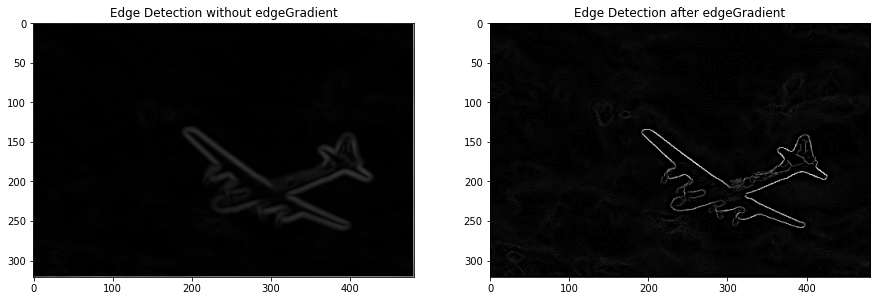

In [157]:
new_img1 = np.zeros((img.shape[0],img.shape[1]))
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        new_img1[i][j] = 0.3*Rgradient[i][j].mag
        new_img1[i][j] += 0.59*Ggradient[i][j].mag
        new_img1[i][j] += 0.11*Bgradient[i][j].mag
new_img2 = np.zeros((img.shape[0],img.shape[1]))
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        new_img2[i][j] = 0.3*edged_image_R[i][j]
        new_img2[i][j] += 0.59*edged_image_G[i][j]
        new_img2[i][j] += 0.11*edged_image_B[i][j]
        
canny_filtered_img = plt.figure(figsize = (15,9))
plt.subplot(1,2,1)
plt.title("Edge Detection without edgeGradient")
plt.imshow(new_img1, cmap = 'gray')
plt.subplot(1,2,2)
plt.title("Edge Detection after edgeGradient")
plt.imshow(new_img2, cmap = 'gray')
canny_filtered_img.savefig("Output/pb2/cannyfilter1.png")

## Subpart 2: Improved Edge Detection (8 points)
Try to improve your results using a set of oriented filters, rather than the simple derivative of Gaussian approach above, including the following functions:
```
def orientedFilterMagnitude(im):
```
Computes the boundary magnitude and orientation using a set of oriented filters, such as elongated Gaussian derivative filters. Explain your choice of filters in the write-up. Use at least four orientations. One way to combine filter responses is to compute a boundary score for each filter (simply by filtering with it) and then use the max and argmax over filter responses to compute the magnitude and orientation for each pixel.
```
def edgeOrientedFilters(im):
```
Similar to Subpart 1, this should call orientedFilterMagnitude, perform the non-maxima suppression, and output the final soft edge map.

In [167]:
def orientedFilterMagnitude(im, mode):
    import skimage
    '''
    im: input image
    outputs: gradient magnitude and gradient direction of the image
    '''
    print("Processing data...")
    ## Bandpass gaussian
    if mode == 1:
        blur_img = skimage.filters.difference_of_gaussians(img, low_sigma=2, high_sigma = 10, truncate=1/5, channel_axis=3)
    else:
        blur_img = im
        
    patch_size = 3
    half_patch_size = math.floor(patch_size/2)
    stride = 1
    ## padding the image to also calcuate the edges of the image
    blur_img = zero_padding(blur_img, half_patch_size)  
    row = blur_img.shape[0]
    col = blur_img.shape[1]
    channels = blur_img.shape[2]
#     print("Padded image size:", row, col, channels)
    
    R_component = []
    G_component = []
    B_component = []
    for i in range(half_patch_size, row-half_patch_size, 1):
        R_row_component = []
        G_row_component = []
        B_row_component = []
        for j in range(half_patch_size, col-half_patch_size, 1):
            ## create patches to calculate the gradient later
            patch = np.zeros((patch_size, patch_size, 3))
            for ii in range(patch_size):    
                for jj in range(patch_size):
                    for kk in range(channels):
                        patch[ii][jj][kk] = blur_img[i-half_patch_size+ii][j-half_patch_size+jj][kk]
            
            for k in range(channels):
                gradient_temp = img_gradient()
                if k == 0:  ## R component
                    gradient_temp.x, gradient_temp.y, gradient_temp.ori = patch_gradient(patch[:,:,0])
                    R_row_component.append(gradient_temp)
                if k == 1: ## G component
                    gradient_temp.x, gradient_temp.y, gradient_temp.ori = patch_gradient(patch[:,:,1])
                    G_row_component.append(gradient_temp)
                elif k == 2:  ## B component
                    gradient_temp.x, gradient_temp.y, gradient_temp.ori = patch_gradient(patch[:,:,2])
                    B_row_component.append(gradient_temp)
                        
        R_component.append(R_row_component)
        G_component.append(G_row_component)
        B_component.append(B_row_component)
    return R_component, G_component, B_component
  
  
  

def edgeOrientedFilters(im):
    '''
    im: input image
    output: a soft boundary map of the image
    '''
    row = im.shape[0]
    col = im.shape[1]
    patch_size = 3
    half_patch_size = math.floor(patch_size/2)
    new_image = np.zeros((row,col))
    for i in range(1,row-1):
        for j in range(1,col-1):
            direction = ''
            direction = get_direction(im[i][j])
            patch = []
            for ii in range(patch_size):
                patch_temp = []
                for jj in range(patch_size):
                    patch_temp.append(im[i-half_patch_size+ii][j-half_patch_size+jj])
                patch.append(patch_temp)
            
            value = thresholding(patch, direction)        
            new_image[i][j] = value
    return new_image
    

In [172]:
'''select mode for different filtering techniques, selection listed below
   Filters                              mode 
   ------------------------------------------------------------------
   Bandpass gaussian filter               1

'''
mode = 1
Rgradient, Ggradient, Bgradient = orientedFilterMagnitude(img, mode)
for i in range(img.shape[0]):  # calculate the magnitude of RGB component
    for j in range(img.shape[1]):
        Rgradient[i][j].cal_magnitude()
        Ggradient[i][j].cal_magnitude()
        Bgradient[i][j].cal_magnitude()
print("edge Gradient calulating")
R_gradient = np.array(Rgradient)
G_gradient = np.array(Ggradient)
B_gradient = np.array(Bgradient)
edged_image_R = edgeGradient(R_gradient)
edged_image_G = edgeGradient(G_gradient)
edged_image_B = edgeGradient(B_gradient)
print("Process Done")

Processing data...
edge Gradient calulating
Process Done


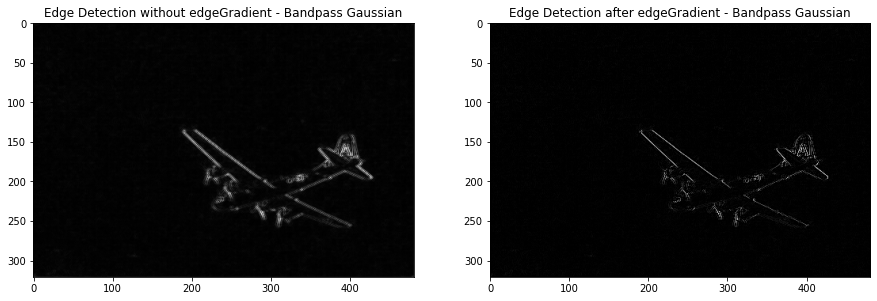

In [174]:
new_img1 = np.zeros((img.shape[0],img.shape[1]))
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        new_img1[i][j] = 0.3*Rgradient[i][j].mag
        new_img1[i][j] += 0.59*Ggradient[i][j].mag
        new_img1[i][j] += 0.11*Bgradient[i][j].mag
new_img2 = np.zeros((img.shape[0],img.shape[1]))
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        new_img2[i][j] = 0.3*edged_image_R[i][j]
        new_img2[i][j] += 0.59*edged_image_G[i][j]
        new_img2[i][j] += 0.11*edged_image_B[i][j]
        
canny_filtered_img1 = plt.figure(figsize = (15,9))
plt.subplot(1,2,1)
plt.title("Edge Detection without edgeGradient - Bandpass Gaussian")
plt.imshow(new_img1, cmap = 'gray')
plt.subplot(1,2,2)
plt.title("Edge Detection after edgeGradient - Bandpass Gaussian")
plt.imshow(new_img2, cmap = 'gray')
canny_filtered_img1.savefig("Output/pb2/cannyfilter-BP gaussian.png")

## Write-up (9 points)

1.   **(2 points)** Description of any design choices and parameters
2.   **(1 points)** The bank of filters used for Subpart 2 ([plt.imshow with extent](https://stackoverflow.com/questions/13384653/imshow-extent-and-aspect/13390798#13390798) or [cv2.normalize to convert output into grayscale](https://stackoverflow.com/questions/39808545/implement-mat2gray-in-opencv-with-python) may help with visualization)
3.   **(5 points)** Qualitative results: choose five example images; show input images and outputs of each edge detector
4.   **(1 points)** Discuss the quality of your outputs and state one possible way for improvement. Improvements could provide, for example, a better boundary pixel score or a better suppression technique. Your idea could come from a paper you read, but cite any sources of ideas.



**Include your write-up here**

# Part D: Template Matching (25 points) 

## Overview
The goal of this part is to build a template maching algorithm for where's waldo puzzle. 
The end product should be finding waldo in puzzle images. 


## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**


In [ ]:
# Download Data -- run this cell only one time per runtime
!gdown 1_PHimFhPSajbTWzAL6-PwM803uzA7Ymb
!unzip "/content/Part4_data.zip" -d "/content/"

Downloading...
From: https://drive.google.com/uc?id=1_PHimFhPSajbTWzAL6-PwM803uzA7Ymb
To: /content/Part4_data.zip
100% 2.04M/2.04M [00:00<00:00, 184MB/s]


## Code

We provide the following functions for plotting your results 


In [ ]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

def plot_image(im,title,xticks=[],yticks= [],cv2 = True):
    """
    im :Image to plot
    title : Title of image 
    xticks : List of tick values. Defaults to nothing
    yticks :List of tick values. Defaults to nothing 
    cv2 :Is the image cv2 image? cv2 images are BGR instead of RGB. Default True
    """
    plt.figure()
    plt.imshow(im[:,:,::-1])
    plt.title(title)
    plt.xticks(xticks)
    plt.yticks(yticks)

It is always advised for you to visualize and get familar with waldo and puzzle image. 

Visualize both the waldo and puzzle images.

In [ ]:
## YOUR CODE HERE

### Subpart 1: Template Matching with OpenCV
OpenCV provide Template Matching functions below link. 

https://docs.opencv.org/4.x/d4/dc6/tutorial_py_template_matching.html

You can use this function for implementing simple where's waldo algorithm.

This part helps you to understand the concepts of Template Matching and OpenCV Library. This is just for reference.

In [ ]:
(waldoHeight, waldoWidth) = waldo.shape[:2]

result = cv2.matchTemplate(map, waldo, cv2.TM_CCOEFF)
(_, _, minLoc, maxLoc) = cv2.minMaxLoc(result)

# grab the bounding box of waldo and extract him from the puzzle image
topLeft = maxLoc
botRight = (topLeft[0] + waldoWidth, topLeft[1] + waldoHeight)
roi = map[topLeft[1] : botRight[1], topLeft[0] : botRight[0]]

# construct a darkened transparent 'layer' to darken everything
# in the map except for Waldo
mask = np.zeros(map.shape, dtype = "uint8")
map = cv2.addWeighted(map, 0.25, mask, 0.75, 0)

map[topLeft[1] : botRight[1], topLeft[0] : botRight[0]] = roi

# display the images
result_rgb = cv2.cvtColor(map, cv2.COLOR_RGB2BGR)
plt.figure(figsize = (15, 15))
plt.imshow(result_rgb)

### Subpart 2: Template Matching from Scratch

Implement the Sum of Squared Distance (SSD) template matching algorithm from scratch (Don't use cv2.matchTemplate).

Then, show the results of where's waldo for two puzzle images.

Hints: You can borrow the codes from Part1 and Part2. Please read methods for matching with filters in Lecture Slide.  

In [ ]:
## YOUR CODE HERE